# SEIR Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.integrate import odeint
from lmfit.lineshapes import gaussian, lorentzian
import lmfit
import datetime as dt

In [2]:
# SEIR(D) - Susceptible Exposed Infected Recovered Dead
# y = conditions vector
# t = time space
# N = population
# beta = expected number of people an infected person infects per day
# gamma = proportion of infected recovering per day
# delta = incubation period
# alpha = death rate
# rho = days from infection until death    

# establishing equations
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

# dummy parameters. somewhat random values, do not use
# N = 1000000
# gamma = 1.0/ 4.0
# delta = 1.0 / 5.0
# beta = 5.0/4.0
# alpha = 0.02
# rho = 1/22
# S0, E0, I0, R0, D0, = N-1, 1, 0, 0, 0

# t = np.linspace(0, 99, 100)
# y0 = S0, E0, I0, R0, D0

# integrating equations over time grid, t
# ret = odeint(deriv, y0, t, args = (N, beta, gamma, delta, alpha, rho))
# df = pd.DataFrame(ret, columns = ['Susceptible', 'Exposed', 'Infected', 'Recovered', 'Dead'])

In [20]:
# create SEIR function. input given parameters and will output S, E, I, R, D over given timespace
def SEIR(days, N, beta, gamma, delta, alpha, rho):
    
    t = np.linspace(0, days-1, days) # creating grid of time points
    y0 = N-1, 1, 0, 0, 0 # initial state vector (S, E, I, R, D). assumes entire population susceptible. begins with 1 exposed
    
    # establishing equations
    def deriv(y, t, N, beta, gamma, delta, alpha, rho):
        S, E, I, R, D = y
        dSdt = -beta * S * I / N
        dEdt = beta * S * I / N - delta * E
        dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
        dRdt = (1 - alpha) * gamma * I
        dDdt = alpha * rho * I
        return dSdt, dEdt, dIdt, dRdt, dDdt

    # integrating equations over time grid, t
    ret = odeint(deriv, y0, t, args = (N, beta, gamma, delta, alpha, rho))
    S, E, I, R, D = ret.T
    
    # in case we want to output a df
    # df = pd.DataFrame(ret, columns = ['Susceptible', 'Exposed', 'Infected', 'Recovered', 'Dead'])
    # df.reset_index(inplace=True)
    # df = df.rename(columns = {'index':'Day'})
    
    return t, S, E, I, R, D

# Parameter Estimation

In [4]:
# quick data cleaning. replace when cleaned df ready
df = pd.read_csv('ny.csv') # load data
df['Date'] = df['Date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d')) # ensure date column correctly formatted
df = df[(df['Province/State'] == 'New York')] # filter to NY only, for testing
df['Population'] = 19378102 # add column containing population info for NY. NOTE: when data is fully cleaned this column will already be in df
df = df[df['Confirmed']>=1] # filter df to begin when the first case occurred

df.head()

,Unnamed: 0,Date,Province/State,Confirmed,Deaths,new_confirmed,new_deaths,new_confirmed_avg,new_deaths_avg,Population
8873,8873,2020-03-03,New York,1,0,1,0,0.142857,0.0,19378102
8874,8874,2020-03-04,New York,10,0,9,0,1.428571,0.0,19378102
8875,8875,2020-03-05,New York,21,0,11,0,3.000000,0.0,19378102
8876,8876,2020-03-06,New York,24,0,3,0,3.428571,0.0,19378102
8877,8877,2020-03-07,New York,76,0,52,0,10.857143,0.0,19378102


In [5]:
# TO DO:
# priority
# make function work with cleaned df
# double check function is working properly
# determine best *current* parameter values to use for projections moving forward

# longer term
# change function to generate best values for every state and return df
# add outbreak shift (input parameter to guess when first true case was)
# updated fixed COVID parameters
# update parameter range, change search method

# function will take cleaned df generate best beta and gamme values for a given state's epidemic curve
def get_best_params(df, state):
    
    # filtering df
    df = df[(df['Province/State'] == state)] # filter to given input state
    df = df[df['Confirmed']>=1] # filter df to begin when the first case occurred. assumption should be changed for the future
    
    # parameters based on input df
    days = len(df) # length of outbreak
    N = df['Population'].iloc[1] # population
    y0 = N-1, 1, 0, 0, 0

    # fixed covid parameters - update in the future
    rho = 1.0/15.0 # 15 days from infection to death, on average. from https://doi.org/10.3390/jcm9020538
    alpha = .0139 # 1.39 death rate. from https://www.medrxiv.org/content/10.1101/2020.06.27.20141689v2
    delta = 1.0/3.0 # incubation period. most studies show a min incubation period of 2 days, with a mean between 3-7. YYG simulator uses 2

    # data from df
    y_data = df['Confirmed'] # case counts
    #y_data = df['Deaths'] # can also fit based on deaths
    t_data = np.linspace(0, days - 1, days, dtype=int) # time vector based on days in df

    # fitter function
    def fitter(x, beta, gamma):
        ret = SEIR(days, N, beta, gamma, rho = 1.0/15.0, alpha = .0139, delta = 1.0/3.0)
        return ret[3][x] # return infections at time x
        # return ret[5][x] # return deaths at time x, if fitting to deaths

    mod = lmfit.Model(fitter) # initialize model
    params_init_min_max = {"beta": (1.0, .05, 2.0), "gamma": (1/12, 1/4, 1/24)} # set parameter range
    for kwarg, (init, mini, maxi) in params_init_min_max.items():
        mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True) # search through parameters
    params = mod.make_params()
    fit_method = "leastsq"

    result = mod.fit(y_data, params, method="least_squares", x = t_data)
    return result.best_values

In [6]:
get_best_params(df, 'New York')

{'beta': 0.3924586961315347, 'gamma': 0.24999999999999997}

# Generate Projections

In [ ]:
# TO DO:
# generate "starting" vector for a given point in time based on the known information

y0 = S, E, I, R, D
S = N - E, I, R, D
E = ??
I = df['Confirmed']
R = ??
D = df['Deaths']

In [ ]:
# plot function
def plotSEIR(t, S, E, I, R, D):
  f, ax = plt.subplots(1,1,figsize=(10,4))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, I, 'y', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
  ax.plot(t, E, 'goldenrod', alpha=0.7, linewidth=2, label='Exposed')
  ax.plot(t, D, 'r', alpha=0.7, linewidth=2, label='Dead')

  ax.set_xlabel('Time (days)')

  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend()
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  plt.show()

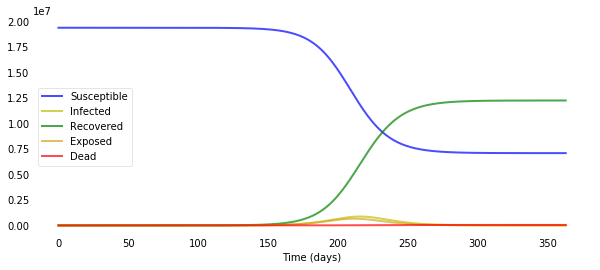

In [21]:
# current "projection" for NY - obviously way off
t, S, E, I, R, D = SEIR(days = 364, N = 19378102, beta = 0.3924586961315347, gamma = 0.24999999999999997, rho = 1.0/15.0, alpha = .0139, delta = 1.0/3.0)

plotSEIR(t, S, E, I, R, D)